In [1]:
import pandas as pd
import numpy as np
from openbb import obb
import datetime as dt
import matplotlib.pyplot as plt

# Create our portfolio of equities
tickers = ['AAPL','META', 'C', 'DIS']

# Set the investment weights (I arbitrarily picked for example)
weights = np.array([.25, .3, .15, .3])

# Set an initial investment level
initial_investment = 1000000

# Download closing prices
data = (obb.equity.price.historical(symbol=tickers, provider='yfinance')
        .to_df()
        .drop(columns=['open', 'high', 'low', 'volume', 'dividend'])
        .pivot(columns='symbol'))

#From the closing prices, calculate periodic returns
returns = data.pct_change()

# returns.tail()

In [31]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix

close                              
symbol            AAPL         C       DIS      META
      symbol                                        
close AAPL    0.000227  0.000039  0.000015  0.000080
      C       0.000039  0.000291  0.000079  0.000063
      DIS     0.000015  0.000079  0.000202  0.000023
      META    0.000080  0.000063  0.000023  0.000363

In [32]:
# Calculate mean returns for each stock
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall,
# using dot product to
# normalize individual means against investment weights
# https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.
port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment

# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

In [36]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
cutoff1

np.float64(983640.6453882146)

In [37]:
#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

np.float64(16359.354611785384)

1 day VaR @ 95% confidence: 16359.35
2 day VaR @ 95% confidence: 23135.62
3 day VaR @ 95% confidence: 28335.23
4 day VaR @ 95% confidence: 32718.71
5 day VaR @ 95% confidence: 36580.63
6 day VaR @ 95% confidence: 40072.07
7 day VaR @ 95% confidence: 43282.78
8 day VaR @ 95% confidence: 46271.24
9 day VaR @ 95% confidence: 49078.06
10 day VaR @ 95% confidence: 51732.82
11 day VaR @ 95% confidence: 54257.84
12 day VaR @ 95% confidence: 56670.47
13 day VaR @ 95% confidence: 58984.49
14 day VaR @ 95% confidence: 61211.1
15 day VaR @ 95% confidence: 63359.51


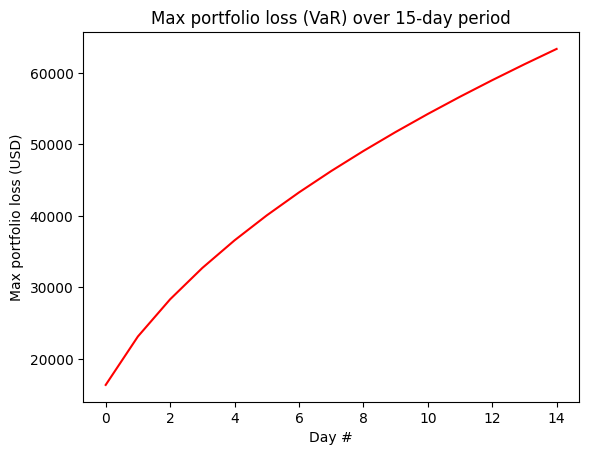

In [35]:
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):
        var_array.append(np.round(var_1d1 * np.sqrt(x),2))
        print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")